In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from genotype_encoder import hw_encoder, encode_one_hot, simple_encoder
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import plotly.express as px
from  scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

In [2]:
MISSING_VAL_ACCEPTANCE_RATIO = 0.20
MIN_MINOR_ALLELE_FREQ = 0.05

### Phenotypes visualization

In [3]:
phenotypes = pd.read_csv('../Dataset/FHB_Traits_ALL.txt', delimiter = '\t')
phenotypes.head(4)

,Taxa,HD50,HT,FHB,SB2,DON,DONLT,Unnamed: 7,Unnamed: 8
0,G1,62.0,76.0,3.2,7.5,20.2,1.2,NaN,NaN
1,G2,62.5,74.5,3.0,7.0,16.5,1.1,NaN,NaN
2,G3,63.3,77.8,2.1,7.5,15.5,1.1,NaN,NaN
3,G4,58.9,67.8,3.0,6.3,25.1,1.3,NaN,NaN


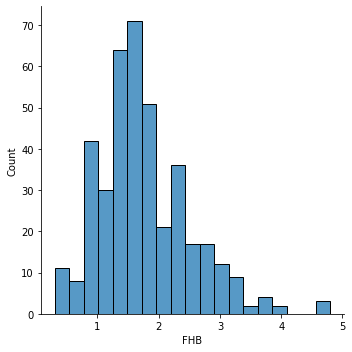

In [4]:
sns.displot(phenotypes, x = 'FHB')

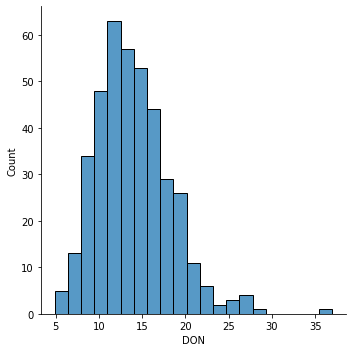

In [5]:
sns.displot(phenotypes, x = 'DON')

<AxesSubplot:xlabel='DON', ylabel='FHB'>

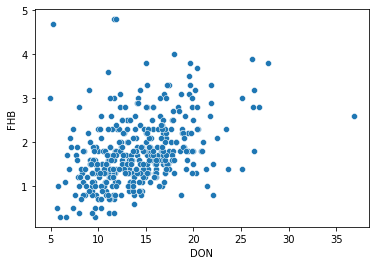

In [6]:
sns.scatterplot(data=phenotypes, x="DON", y="FHB")


In [7]:
pcc, pval = pearsonr(phenotypes["DON"].to_numpy(), phenotypes["FHB"].to_numpy())
print("Pearson correlation between DON and FHB: ", pcc)

Pearson correlation between DON and FHB:  0.3810920204524595


### Germplasm preprocessing

In [8]:
germplasm = pd.read_csv('../Dataset/Genotype-Tucker2.txt', delimiter = '\t', index_col='Name')
germplasm.head(5)

,Index,Address,GenTrain Score,Frac A,Frac C,Frac G,Frac T,G1,G2,G3,...,G391,G392,G393,G394,G395,G396,G397,G398,G399,G400
Name,,,,,,,,,,,,,,,,,,,,,
BK_01,1,75781258,0.270494,0.248521,0.295858,0.248521,0.207101,NC,NC,NC,...,BB,AB,BB,BB,AB,BB,AB,BB,AB,AB
BK_03,2,6656338,0.716519,0.330435,0.121739,0.226087,0.321739,AA,AA,AA,...,AA,NC,NC,BB,AA,AA,NC,BB,NC,AA
BK_04,3,1747980,0.607074,0.146067,0.292135,0.292135,0.269663,BB,BB,BB,...,BB,BB,BB,AA,BB,BB,BB,BB,BB,BB
BK_05,4,53738907,0.623964,0.142857,0.304348,0.279503,0.273292,BB,BB,BB,...,AA,BB,AA,AA,AA,AA,AA,BB,AA,BB
BK_07,5,38671159,0.000000,0.231482,0.185185,0.268518,0.314815,NC,NC,NC,...,AB,BB,BB,AB,BB,AB,BB,AB,BB,AB


In [9]:
germplasm = germplasm.loc[:, 'G1': 'G400']
germplasm.head(5)

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G391,G392,G393,G394,G395,G396,G397,G398,G399,G400
Name,,,,,,,,,,,,,,,,,,,,,
BK_01,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC,...,BB,AB,BB,BB,AB,BB,AB,BB,AB,AB
BK_03,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,...,AA,NC,NC,BB,AA,AA,NC,BB,NC,AA
BK_04,BB,BB,BB,BB,BB,BB,BB,BB,BB,BB,...,BB,BB,BB,AA,BB,BB,BB,BB,BB,BB
BK_05,BB,BB,BB,AA,BB,BB,BB,AA,AA,BB,...,AA,BB,AA,AA,AA,AA,AA,BB,AA,BB
BK_07,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC,...,AB,BB,BB,AB,BB,AB,BB,AB,BB,AB


In [10]:
germplasm = germplasm.T
germplasm.head(5)

Name,BK_01,BK_03,BK_04,BK_05,BK_07,BK_08,BK_09,BK_10,BK_11,BK_12,...,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_98829,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_99836,SCRI_RS_9991,SCRI_RS_99965
G1,NC,AA,BB,BB,NC,AA,AA,BB,BB,AA,...,BB,AA,BB,AA,BB,BB,AA,BB,AA,NC
G2,NC,AA,BB,BB,NC,AA,AA,BB,BB,AA,...,AA,AA,BB,AA,BB,BB,AA,BB,AA,NC
G3,NC,AA,BB,BB,NC,AA,AA,BB,BB,AA,...,BB,AA,BB,AA,BB,BB,AA,BB,AA,NC
G4,NC,AA,BB,AA,NC,BB,AA,BB,BB,AA,...,AA,BB,BB,AA,BB,BB,AA,BB,AA,NC
G5,NC,AA,BB,BB,NC,BB,AA,BB,BB,AA,...,AA,BB,BB,AA,BB,BB,AA,BB,AA,NC


In [11]:
def removeMissingValueMoreThanN(germplasm, percentage):
    #germplasm - a dataframe array
    counts = germplasm == 'NC'
    counts = counts.sum() / len(germplasm) 
    ind = counts < percentage

    germplasm = germplasm.loc[:, ind]
    
    return germplasm

In [12]:
def removeMinorAlleleLessThanN(germplasm, percentage):
    count_homo_1 = germplasm == 'AA'
    count_hetero = germplasm == 'AB'
    count_homo_1 = count_homo_1.sum()
    count_hetero = count_hetero.sum()
    
    allele_1_freq = (2 * count_homo_1 + count_hetero) / (2 * len(germplasm))
    
    ind_to_remove = (allele_1_freq < (1-percentage)) & (allele_1_freq > percentage)
    
    germplasm = germplasm.loc[:, ind_to_remove]
    
    return germplasm
    

In [13]:
germplasm = removeMissingValueMoreThanN(germplasm, MISSING_VAL_ACCEPTANCE_RATIO)
germplasm.head(5)

Name,BK_04,BK_05,BK_08,BK_09,BK_10,BK_11,BK_12,BK_13,BK_14,BK_19,...,SCRI_RS_98293,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_98829,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_99836,SCRI_RS_9991
G1,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,AA,BB,AA,BB,AA,BB,BB,AA,BB,AA
G2,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,BB,AA,AA,BB,AA,BB,BB,AA,BB,AA
G3,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,AA,BB,AA,BB,AA,BB,BB,AA,BB,AA
G4,BB,AA,BB,AA,BB,BB,AA,BB,AA,BB,...,AA,AA,BB,BB,AA,BB,BB,AA,BB,AA
G5,BB,BB,BB,AA,BB,BB,AA,BB,AA,BB,...,AA,AA,BB,BB,AA,BB,BB,AA,BB,AA


In [14]:
germplasm = germplasm.replace('NC', np.nan)
germplasm.head(5)

Name,BK_04,BK_05,BK_08,BK_09,BK_10,BK_11,BK_12,BK_13,BK_14,BK_19,...,SCRI_RS_98293,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_98829,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_99836,SCRI_RS_9991
G1,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,AA,BB,AA,BB,AA,BB,BB,AA,BB,AA
G2,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,BB,AA,AA,BB,AA,BB,BB,AA,BB,AA
G3,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,AA,BB,AA,BB,AA,BB,BB,AA,BB,AA
G4,BB,AA,BB,AA,BB,BB,AA,BB,AA,BB,...,AA,AA,BB,BB,AA,BB,BB,AA,BB,AA
G5,BB,BB,BB,AA,BB,BB,AA,BB,AA,BB,...,AA,AA,BB,BB,AA,BB,BB,AA,BB,AA


In [15]:
germplasm = germplasm.fillna(germplasm.mode().iloc[0])
germplasm.head(5)

Name,BK_04,BK_05,BK_08,BK_09,BK_10,BK_11,BK_12,BK_13,BK_14,BK_19,...,SCRI_RS_98293,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_98829,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_99836,SCRI_RS_9991
G1,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,AA,BB,AA,BB,AA,BB,BB,AA,BB,AA
G2,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,BB,AA,AA,BB,AA,BB,BB,AA,BB,AA
G3,BB,BB,AA,AA,BB,BB,AA,BB,AA,BB,...,AA,BB,AA,BB,AA,BB,BB,AA,BB,AA
G4,BB,AA,BB,AA,BB,BB,AA,BB,AA,BB,...,AA,AA,BB,BB,AA,BB,BB,AA,BB,AA
G5,BB,BB,BB,AA,BB,BB,AA,BB,AA,BB,...,AA,AA,BB,BB,AA,BB,BB,AA,BB,AA


In [16]:
germplasm = removeMinorAlleleLessThanN(germplasm, MIN_MINOR_ALLELE_FREQ)
germplasm.head(5)

Name,BK_05,BK_08,BK_12,BK_13,BK_14,BOPA1_10012-1239,BOPA1_1007-651,BOPA1_10126-999,BOPA1_10207-1024,BOPA1_10248-954,...,SCRI_RS_97418,SCRI_RS_98248,SCRI_RS_98293,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_9991
G1,BB,AA,AA,BB,AA,AA,AA,BB,AA,BB,...,AA,AA,AA,BB,AA,AA,BB,BB,AA,AA
G2,BB,AA,AA,BB,AA,AA,AA,BB,BB,BB,...,AA,AA,BB,AA,AA,AA,BB,BB,AA,AA
G3,BB,AA,AA,BB,AA,AA,AA,BB,AA,BB,...,AA,AA,AA,BB,AA,AA,BB,BB,AA,AA
G4,AA,BB,AA,BB,AA,AA,AA,BB,AA,BB,...,AA,AA,AA,AA,BB,AA,BB,BB,AA,AA
G5,BB,BB,AA,BB,AA,AA,AA,BB,AA,BB,...,AA,AA,AA,AA,BB,AA,BB,BB,AA,AA


### dividing the data in k fold

In [17]:
germplasm, validation_germplasm, phenotypes, validation_phenotypes = train_test_split(germplasm, phenotypes[['FHB', 'DON']], test_size = 0.2, random_state = 42)

In [18]:
validation_data = pd.concat([validation_germplasm.reset_index(drop=True), validation_phenotypes.reset_index(drop=True)], axis = 1, ignore_index= True) 

In [19]:
validation_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,24858,24859,24860,24861,24862,24863,24864,24865,24866,24867
0,BB,AA,BB,AA,BB,AA,AA,BB,BB,BB,...,BB,AA,BB,AA,BB,AA,AA,BB,4.8,11.7
1,BB,AA,AA,BB,AA,AA,BB,AA,BB,BB,...,BB,AA,AA,BB,BB,BB,AA,AA,0.8,12.4
2,BB,AA,AA,BB,AA,AA,BB,BB,AA,BB,...,BB,AA,AA,BB,BB,BB,AA,AA,1.8,17.4
3,AA,AA,BB,AA,BB,AA,AA,BB,BB,BB,...,BB,AA,BB,AA,BB,AA,AA,BB,4.8,11.9
4,BB,AA,AA,BB,AA,AA,AA,BB,AA,BB,...,BB,AA,BB,BB,AA,BB,AA,AA,1.4,11.2


In [20]:
validation_germplasm.head(5)

Name,BK_05,BK_08,BK_12,BK_13,BK_14,BOPA1_10012-1239,BOPA1_1007-651,BOPA1_10126-999,BOPA1_10207-1024,BOPA1_10248-954,...,SCRI_RS_97418,SCRI_RS_98248,SCRI_RS_98293,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_9991
G210,BB,AA,BB,AA,BB,AA,AA,BB,BB,BB,...,BB,BB,BB,AA,BB,AA,BB,AA,AA,BB
G281,BB,AA,AA,BB,AA,AA,BB,AA,BB,BB,...,BB,BB,BB,AA,AA,BB,BB,BB,AA,AA
G34,BB,AA,AA,BB,AA,AA,BB,BB,AA,BB,...,BB,BB,BB,AA,AA,BB,BB,BB,AA,AA
G211,AA,AA,BB,AA,BB,AA,AA,BB,BB,BB,...,BB,BB,BB,AA,BB,AA,BB,AA,AA,BB
G94,BB,AA,AA,BB,AA,AA,AA,BB,AA,BB,...,AA,BB,BB,AA,BB,BB,AA,BB,AA,AA


In [21]:
validation_data.to_pickle('../Dataset/validation_raw_.pkl')

In [22]:
kf = KFold(n_splits = 5, random_state = 42, shuffle=True)

ind = 0 
for train_ind, test_ind in kf.split(germplasm):
    
    #train test split raw data
    tr_germplasm = germplasm.iloc[train_ind]
    test_germplasm = germplasm.iloc[test_ind]
    
    tr_pheno = phenotypes.iloc[train_ind]
    test_pheno = phenotypes.iloc[test_ind]
    
    tr_data = pd.concat([tr_germplasm.reset_index(drop=True), tr_pheno.reset_index(drop=True)], axis = 1)
    test_data = pd.concat([test_germplasm.reset_index(drop=True), test_pheno.reset_index(drop=True)], axis = 1)
    
    tr_data.to_pickle('../Dataset/tr_raw_fold_' + str(ind) + '.pkl')
    test_data.to_pickle('../Dataset/test_raw_fold_' + str(ind) + '.pkl')
    
    #raw data in hardy weinberg encoded
    hw = hw_encoder('AA', 'BB', 'AB')
    
    germplasm_hw_tr = hw.fit_transform(tr_germplasm.copy(deep = True))
    germplasm_hw_test = hw.transform(test_germplasm.copy(deep = True))
    germplasm_hw_validation = hw.transform(validation_germplasm.copy(deep = True))
    
    tr_data = pd.concat([germplasm_hw_tr.reset_index(drop=True), tr_pheno.reset_index(drop=True)], axis = 1)
    test_data = pd.concat([germplasm_hw_test.reset_index(drop=True), test_pheno.reset_index(drop=True)], axis = 1)
    validation_data = pd.concat([germplasm_hw_validation.reset_index(drop=True), validation_phenotypes.reset_index(drop=True)], axis = 1) 
    
    tr_data.to_pickle('../Dataset/tr_hw_fold_' + str(ind) + '.pkl')
    test_data.to_pickle('../Dataset/test_hw_fold_' + str(ind) + '.pkl')
    validation_data.to_pickle('../Dataset/validation_hw.pkl')
    
    #raw data in simple 1, 0, -1 encoding
#     genotypes = ['AA', 'AB', 'BB']
#     representations = [1, 0, -1]
    
#     enc = simple_encoder(genotypes, representations)
#     germplasm_sm_tr = enc.fit_transform(tr_germplasm.to_numpy())
    

    
    
    
    
    
    
#     = enc.fit_transform(test_germplasm.to_numpy())
#     if ind == 0:
#         germplasm_sm_validation = enc.fit_transform(validation_germplasm.to_numpy())
#         validation_data = pd.concat([validation_germplasm.reset_index(drop=True), validation_phenotypes.reset_index(drop=True)], axis = 1) 
#         validation_data.to_pickle('../Dataset/validation_sm.pkl')

#     germplasm_sm_tr = pd.DataFrame(data= germplasm_sm_tr, columns= tr_germplasm.columns)
#     germplasm_sm_test = pd.DataFrame(data= germplasm_sm_test, columns= test_germplasm.columns)
    
#     tr_data = pd.concat([germplasm_sm_tr.reset_index(drop=True), tr_pheno.reset_index(drop=True)], axis = 1)
#     test_data = pd.concat([germplasm_sm_test.reset_index(drop=True), test_pheno.reset_index(drop=True)], axis = 1)
    
#     tr_data.to_pickle('../Dataset/tr_sm_fold_' + str(ind) + '.pkl')
#     test_data.to_pickle('../Dataset/test_sm_fold_' + str(ind) + '.pkl')
    
#     #one hot encoding
#     germplasm_one_hot_tr = encode_one_hot(tr_germplasm.copy(deep=True), genotypes)
#     germplasm_one_hot_test = encode_one_hot(test_germplasm.copy(deep=True), genotypes)
#     if ind == 0:
#         germplasm_oh_validation = encode_one_hot(validation_germplasm.copy(deep=True), genotypes)
#         validation_data = pd.DataFrame({
#             'data': list(map(lambda x: x.tolist(), germplasm_oh_validation)),
#             'DON': validation_phenotypes['DON'].to_numpy(),
#             'FHB': validation_phenotypes['FHB'].to_numpy()
#         }) 
#         validation_data.to_pickle('../Dataset/validation_oh.pkl')
        
#     tr_data = pd.DataFrame({
#         'data': list(map(lambda x: x.tolist(), germplasm_one_hot_tr)),
#         'DON': tr_pheno['DON'].to_numpy(),
#         'FHB': tr_pheno['FHB'].to_numpy()
#     })
    
#     test_data = pd.DataFrame({
#         'data': list(map(lambda x: x.tolist(), germplasm_one_hot_test)),
#         'DON': test_pheno['DON'].to_numpy(),
#         'FHB': test_pheno['FHB'].to_numpy()
#     })
    
#     tr_data.to_pickle('../Dataset/tr_oh_fold_' + str(ind) + '.pkl')
#     test_data.to_pickle('../Dataset/test_oh_fold_' + str(ind) + '.pkl')

    
    ind += 1


In [23]:
tr_hw = pd.read_pickle('../Dataset/tr_hw_fold_0.pkl')
tr_hw.head(5)

,BK_05,BK_08,BK_12,BK_13,BK_14,BOPA1_10012-1239,BOPA1_1007-651,BOPA1_10126-999,BOPA1_10207-1024,BOPA1_10248-954,...,SCRI_RS_98293,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_9991,FHB,DON
0,0.478043,0.035156,0.738525,0.752014,0.738525,0.711914,0.112854,0.486179,0.478043,0.814224,...,0.003666,0.930923,0.061527,0.111546,0.779358,0.380920,0.871597,0.505432,3.0,25.1
1,0.095230,0.035156,0.738525,0.752014,0.738525,0.024414,0.112854,0.091648,0.478043,0.009537,...,0.882572,0.930923,0.565434,0.443577,0.779358,0.380920,0.871597,0.505432,3.3,17.4
2,0.478043,0.035156,0.738525,0.752014,0.738525,0.024414,0.440979,0.091648,0.478043,0.814224,...,0.882572,0.930923,0.061527,0.443577,0.779358,0.380920,0.871597,0.083557,0.7,11.2
3,0.478043,0.660156,0.738525,0.752014,0.738525,0.711914,0.112854,0.486179,0.095230,0.814224,...,0.882572,0.930923,0.565434,0.111546,0.779358,0.146545,0.871597,0.505432,0.7,10.0
4,0.478043,0.660156,0.019775,0.017639,0.019775,0.711914,0.440979,0.486179,0.478043,0.814224,...,0.882572,0.930923,0.565434,0.443577,0.779358,0.146545,0.871597,0.083557,1.4,12.7


In [24]:
test_hw = pd.read_pickle('../Dataset/test_hw_fold_0.pkl')
test_hw.head(5)

,BK_05,BK_08,BK_12,BK_13,BK_14,BOPA1_10012-1239,BOPA1_1007-651,BOPA1_10126-999,BOPA1_10207-1024,BOPA1_10248-954,...,SCRI_RS_98293,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_9991,FHB,DON
0,0.478043,0.660156,0.738525,0.752014,0.738525,0.711914,0.440979,0.486179,0.095230,0.814224,...,0.882572,0.930923,0.565434,0.111546,0.779358,0.380920,0.871597,0.505432,1.2,8.8
1,0.478043,0.660156,0.019775,0.017639,0.019775,0.711914,0.440979,0.486179,0.478043,0.814224,...,0.882572,0.930923,0.565434,0.443577,0.779358,0.146545,0.871597,0.505432,2.3,20.5
2,0.478043,0.660156,0.019775,0.017639,0.019775,0.711914,0.440979,0.486179,0.095230,0.814224,...,0.882572,0.930923,0.565434,0.443577,0.779358,0.380920,0.871597,0.505432,1.6,9.4
3,0.478043,0.660156,0.738525,0.752014,0.738525,0.711914,0.112854,0.486179,0.478043,0.814224,...,0.882572,0.930923,0.565434,0.443577,0.779358,0.380920,0.871597,0.505432,1.3,8.3
4,0.478043,0.660156,0.738525,0.752014,0.738525,0.711914,0.440979,0.486179,0.478043,0.814224,...,0.882572,0.930923,0.565434,0.111546,0.013733,0.380920,0.871597,0.505432,2.5,12.5


In [25]:
val_hw = pd.read_pickle('../Dataset/validation_hw.pkl')
val_hw.head(5)

,BK_05,BK_08,BK_12,BK_13,BK_14,BOPA1_10012-1239,BOPA1_1007-651,BOPA1_10126-999,BOPA1_10207-1024,BOPA1_10248-954,...,SCRI_RS_98293,SCRI_RS_98343,SCRI_RS_98443,SCRI_RS_99344,SCRI_RS_994,SCRI_RS_99798,SCRI_RS_9980,SCRI_RS_9991,FHB,DON
0,0.079102,0.666519,0.017639,0.016617,0.017639,0.698792,0.110245,0.494385,0.074768,0.814224,...,0.864319,0.915909,0.060562,0.092834,0.821289,0.143570,0.875248,0.064468,4.8,11.7
1,0.079102,0.666519,0.752014,0.758804,0.752014,0.698792,0.446182,0.088135,0.074768,0.814224,...,0.864319,0.915909,0.568375,0.483459,0.821289,0.385757,0.875248,0.556656,0.8,12.4
2,0.079102,0.666519,0.752014,0.758804,0.752014,0.698792,0.446182,0.494385,0.527893,0.814224,...,0.864319,0.915909,0.568375,0.483459,0.821289,0.385757,0.875248,0.556656,1.8,17.4
3,0.516602,0.666519,0.017639,0.016617,0.017639,0.698792,0.110245,0.494385,0.074768,0.814224,...,0.864319,0.915909,0.060562,0.092834,0.821289,0.143570,0.875248,0.064468,4.8,11.9
4,0.079102,0.666519,0.752014,0.758804,0.752014,0.698792,0.110245,0.494385,0.527893,0.814224,...,0.864319,0.915909,0.060562,0.483459,0.008789,0.385757,0.875248,0.556656,1.4,11.2
